<a href="https://colab.research.google.com/github/e-moncao-lima/BMC/blob/master/analise_microdados_ENEM_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANÁLISE DOS MICRODADOS DO ENEM 2019**






# Bibliotecas



*pandas*: para carregar os dados em um dataframe.

*numpy*: para realizar operações numéricas

*seaborn*: para plotar gráficos estatisticos

*matplotlib*: para plotar gráficos

*scipy*: para realizar cálculos estatísticos

*statsmodel*: para realizar a análise multivariada de variância (MANOVA)

*zipfile*: para descompactar arquivos

*time*: para medir tempo

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from scipy import stats

from zipfile import ZipFile
import time

# Coleta e Pré-processamento de Dados

Extraindo o arquivo .csv da pasta .zip contendo microdados do ENEM 2019


In [10]:
# complete original file stored on this Drive 
zipdata_path = '/content/drive/My Drive/Colab Notebooks/Dados/microdados_enem_2019.zip'

with ZipFile(zipdata_path, 'r') as zipfile:
  zipfile.extract('DADOS/MICRODADOS_ENEM_2019.csv')

Recebendo os dados do arquivo .csv. Será dividido em partes (*chunks*) visto que o arquivo é grande.

In [11]:
data_path = '/content/DADOS/MICRODADOS_ENEM_2019.csv'
chunk_enem2019 = pd.read_csv(data_path, sep=';', chunksize=1000000, encoding='latin-1')   # a codificacao do arquivo nao e a padrao UTF-8 

Pré-processando cada *chunk* antes de concatenar todos num só dataframe.


In [12]:
columns_to_drop = ['CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA',
                   'CO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'SG_UF_NASCIMENTO', 'NO_MUNICIPIO_NASCIMENTO',
                   'CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC','CO_UF_ESC',
                   'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA', 'CO_PROVA_CN',
                   'TP_LINGUA', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 
                   'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH',
                   'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC',
                   'TX_GABARITO_MT']

def preprocessing_chunk(chunk):
  # excluindo colunas desnecessarias
  df = chunk.drop(labels=columns_to_drop, axis=1)

  # excluindo os ausentes na prova
  df_presentes = df[df.TP_PRESENCA_CN==1]
  df_presentes = df[df.TP_PRESENCA_CH==1]
  df_presentes = df[df.TP_PRESENCA_LC==1]
  df_presentes = df[df.TP_PRESENCA_MT==1]

  # Considerando apenas quem concluiu a redacao sem problemas
  df_presentes = df_presentes[df_presentes.TP_STATUS_REDACAO==1]
  
  # Excluindo as colunas ja que nao serao analisadas
  df_presentes = df_presentes.drop(labels=['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 
                                    'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
                                    'TP_STATUS_REDACAO'], axis=1)


  print(df_presentes.shape)
  return df_presentes

Concatenando as partes pre-processadas

In [13]:
list_enem2019 = []

for chunk in chunk_enem2019:
  chunk_preprocessed = preprocessing_chunk(chunk)
  list_enem2019.append(chunk_preprocessed)
df_enem2019 = pd.concat(list_enem2019)

(745356, 98)
(728492, 98)
(720233, 98)
(716297, 98)
(628675, 98)
(57064, 98)


In [14]:
df_enem2019.shape

(3596117, 98)

In [15]:
## change data types (to save up memory usage)    
# Economiza em torno de 1 GB RAM - quase metade
list_col_dtype = [col for col in df_enem2019.columns]

start_time = time.time()
for col in df_enem2019.columns:
   if df_enem2019[col].dtypes == np.int64:
     df_enem2019[col] = df_enem2019[col].astype(np.int32)
   elif df_enem2019[col].dtypes == np.float64:
     df_enem2019[col] = df_enem2019[col].astype(np.float32)
end_time = time.time()

print('Tempo de execução: {:.2f} segundos'.format(end_time-start_time))

Tempo de execução: 12.70 segundos


# Exploratory Data Analysis

## Configurando coluna-alvo

Criando uma coluna com a media das notas das 4 provas e redação

In [16]:
df_enem2019['NU_MEDIA_NOTAS'] = df_enem2019[['NU_NOTA_CN', 'NU_NOTA_CH', 
                                             'NU_NOTA_LC', 'NU_NOTA_MT',
                                             'NU_NOTA_REDACAO']].mean(axis=1, skipna=False)

Apagando as colunas das notas para economizar espaco no disco

In [17]:
df_enem2019 = df_enem2019.drop(labels=['NU_NOTA_CN', 'NU_NOTA_CH',
                                       'NU_NOTA_LC', 'NU_NOTA_MT',
                                       'NU_NOTA_REDACAO'], axis=1)

In [18]:
df_enem2019['NU_MEDIA_NOTAS'].isna().sum()

0

In [19]:
# Excluir caso haja alguma média NaN
# df_enem2019.dropna(subset=['NU_MEDIA_NOTAS'], inplace=True)

## Agrupando e Codificando Dados 

Indicador de pedido de atendimento especializado

In [20]:
list_especial = ['IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
                 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
                 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
                 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF']

df_enem2019['IN_ATEND_ESPECIALIZADO'] = df_enem2019.loc[:, list_especial].max(1)

Indicador de pedido de atendimento especifico

In [21]:
list_especifico = ['IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR']

df_enem2019['IN_ATEND_ESPECIFICO'] = df_enem2019.loc[:, list_especifico].max(1)

Indicador de pedidos de recursos especializados e especificos para a realizacao das provas

In [22]:
list_recurso = ['IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO',
                'IN_TRANSCRICAO', 'IN_LIBRAS', 'IN_TEMPO_ADICIONAL', 'IN_LEITURA_LABIAL',
                'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA',
                'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL',
                'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO',
                'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR',
                'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO',
                'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL', 'IN_SALA_ESPECIAL',
                'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATERIAL_ESPECIFICO',
                'IN_NOME_SOCIAL']

# Como ja existe uma coluna 'IN_SEM_RECURSO' que indica se o inscrito
# fez ou nao um pedido de recurso especial ou especifico, basta apagar
# as outras colunas
df_enem2019.drop(labels=list_recurso, axis =1, inplace=True)

In [23]:
df_enem2019.drop(labels=list_especial, axis=1, inplace=True)
df_enem2019.drop(labels=list_especifico, axis=1, inplace=True)

In [24]:
df_enem2019.shape   # Reduziu drasticamente as dimensoes

(3596117, 46)

Vendo a proporção de dados não respondidos ou não informados

In [25]:
print('TP_ESCOLA NR: {:.1f}%'.format(df_enem2019[df_enem2019['TP_ESCOLA']==1].shape[0]/df_enem2019.shape[0]*100))
print('TP_ENSINO NaN: {:.1f}%'.format(df_enem2019['TP_ENSINO'].isna().sum()/df_enem2019.shape[0]*100))
print('TP_DEPENDENCIA_ADM_ESC NaN: {:.1f}%'.format(df_enem2019['TP_DEPENDENCIA_ADM_ESC'].isna().sum()/df_enem2019.shape[0]*100))
print('TP_LOCALIZACAO_ESC NaN: {:.1f}%'.format(df_enem2019['TP_LOCALIZACAO_ESC'].isna().sum()/df_enem2019.shape[0]*100))
print('TP_SIT_FUNC_ESC NaN: {:.1f}%'.format(df_enem2019['TP_SIT_FUNC_ESC'].isna().sum()/df_enem2019.shape[0]*100))

TP_ESCOLA NR: 67.3%
TP_ENSINO NaN: 42.6%
TP_DEPENDENCIA_ADM_ESC NaN: 74.4%
TP_LOCALIZACAO_ESC NaN: 74.4%
TP_SIT_FUNC_ESC NaN: 74.4%


Decidiu-se considerar apenas aqueles que responderam na coluna TP_ESCOLA, assumir os dados NaN da coluna TP_ENSINO como 1 (Ensino Regular) e desconsiderar as colunas TP_DEPENDENCIA_ADM_ESC, TP_LOCALIZACAO_ESC e TP_SIT_FUNC_ESC da análise

In [26]:
df_enem2019 = df_enem2019[df_enem2019.TP_ESCOLA!=1]
df_enem2019['TP_ENSINO'].fillna(value=1, axis=0, inplace=True)

columns_to_drop = ['TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC']
df_enem2019.drop(labels=columns_to_drop, axis=1, inplace=True)

df_enem2019.reset_index(drop=True, inplace=True)

In [27]:
df_enem2019.TP_ENSINO = df_enem2019.TP_ENSINO.astype('int32')
df_enem2019.head()

,NU_INSCRICAO,NU_ANO,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,SG_UF_ESC,IN_SEM_RECURSO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_MEDIA_NOTAS,IN_ATEND_ESPECIALIZADO,IN_ATEND_ESPECIFICO
0,1022443605,2019,15,18,F,1,1,1,2,0,3,1,0,PA,0,H,E,A,D,3,C,D,E,E,C,A,B,C,B,A,B,A,A,D,B,B,D,A,C,B,581.400024,0,0
1,1022443610,2019,15,26,F,0,3,1,2,0,2,1,0,PA,0,B,B,B,B,4,B,A,B,B,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A,423.460022,0,0
2,1022443618,2019,15,17,F,1,3,1,2,0,2,1,0,PA,0,B,D,B,B,3,C,A,B,C,A,B,B,A,A,A,A,A,A,B,B,A,D,A,A,A,461.259949,0,0
3,1022443619,2019,15,17,F,1,3,1,2,0,2,1,0,PA,0,E,E,B,B,9,C,A,B,D,A,A,B,A,A,A,A,A,A,D,A,A,C,A,A,A,468.200012,0,0
4,1022443621,2019,15,18,F,1,3,1,2,0,2,1,0,NaN,0,E,E,B,B,8,D,A,B,B,A,B,B,A,B,A,A,A,A,B,A,A,B,A,A,A,514.400024,0,0


Organizando as colunas dicotômicas

In [28]:
# Codificando a variavel dicotomica em 0 e 1
df_enem2019.TP_SEXO.replace(to_replace=['M', 'F'], value=[0, 1], inplace=True)
df_enem2019.TP_SEXO = df_enem2019.TP_SEXO.astype('int32')

Visualização da comparação das variáveis *TP_SEXO* e *IN_ATEND_ESPECIFICO* (que apresentaram correlações maiores) com efeito na Nota Média no ENEM 2019 e da distribuição das notas entre as categorias.

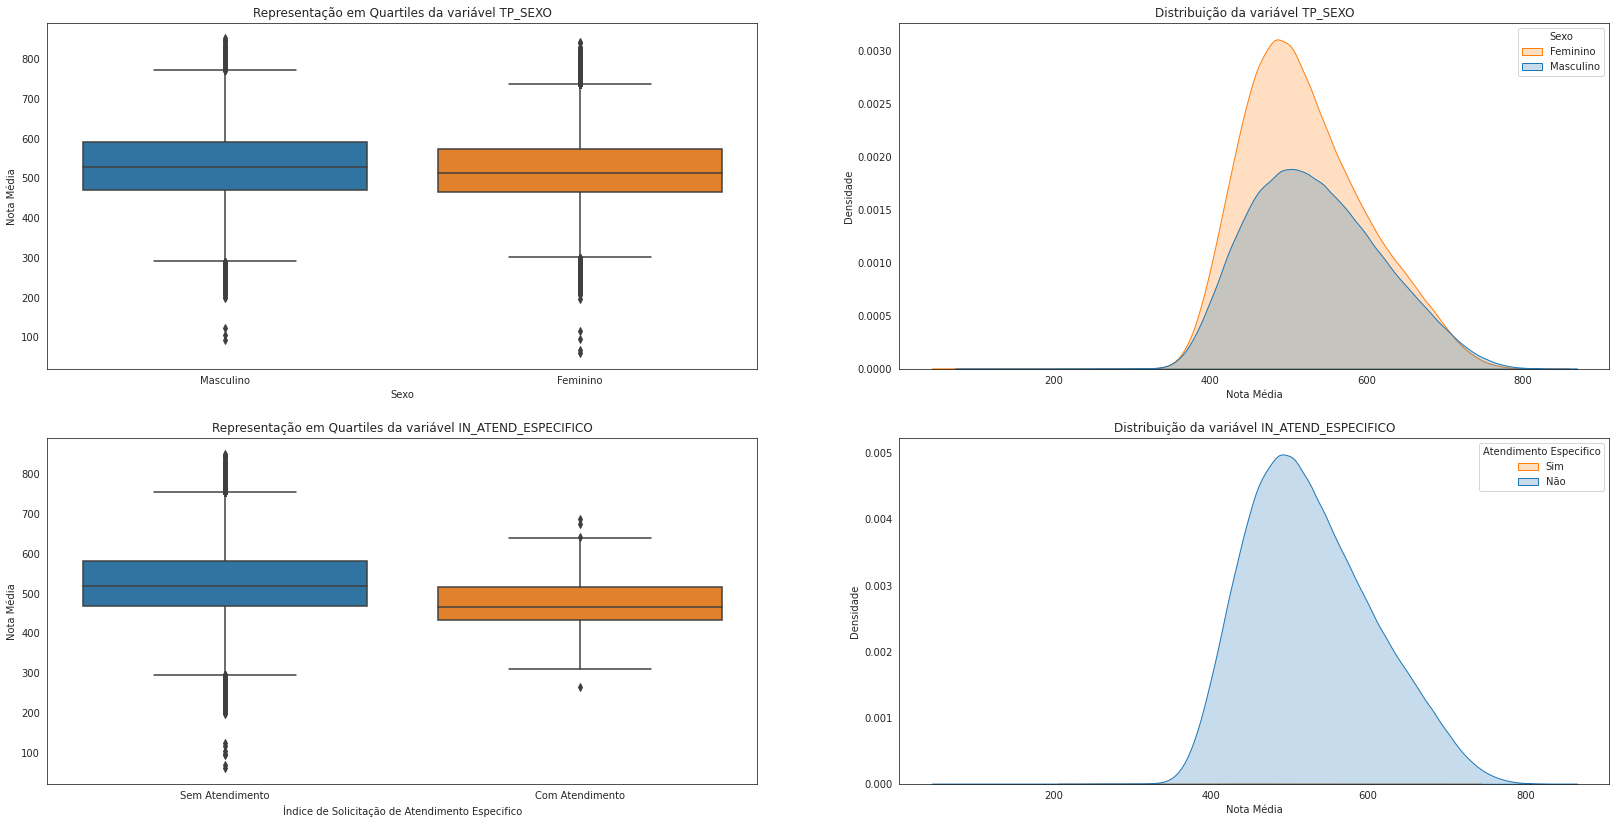

In [29]:
sns.set_style('white')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(28, 14))

# TP_SEXO - BOXPLOT
g1 = sns.boxplot(data=df_enem2019,
                 x='TP_SEXO',
                 y='NU_MEDIA_NOTAS',
                 ax=ax[0][0])
g1.set_title('Representação em Quartiles da variável TP_SEXO')
g1.set_xticklabels(['Masculino', 'Feminino'])     # Sendo 0 - Masc e 1 - Fem
g1.set_xlabel('Sexo')
g1.set_ylabel('Nota Média')

# TP_SEXO - KDE
g2 = sns.kdeplot(data=df_enem2019,
                 x='NU_MEDIA_NOTAS',
                 hue='TP_SEXO',
                 fill=True,
                 ax=ax[0][1])
g2.set_title('Distribuição da variável TP_SEXO')
g2.legend(['Feminino', 'Masculino']).set_title('Sexo')
g2.set_xlabel('Nota Média')
g2.set_ylabel('Densidade')

# IN_ATEND_ESPECIFICO - BOXPLOT
g3 = sns.boxplot(data=df_enem2019,
                 x='IN_ATEND_ESPECIFICO',
                 y='NU_MEDIA_NOTAS',
                 ax=ax[1][0])
g3.set_title('Representação em Quartiles da variável IN_ATEND_ESPECIFICO')
g3.set_xticklabels(['Sem Atendimento', 'Com Atendimento'])     # Sendo 0 - Masc e 1 - Fem
g3.set_xlabel('Índice de Solicitação de Atendimento Especifico')
g3.set_ylabel('Nota Média')

# IN_ATEND_ESPECIFICO - KDE
g4 = sns.kdeplot(data=df_enem2019,
                 x='NU_MEDIA_NOTAS',
                 hue='IN_ATEND_ESPECIFICO',
                 fill=True,
                 ax=ax[1][1])
g4.set_title('Distribuição da variável IN_ATEND_ESPECIFICO')
g4.legend(['Sim', 'Não']).set_title('Atendimento Especifico')
g4.set_xlabel('Nota Média')
g4.set_ylabel('Densidade')


plt.show()

Text(0, 0.5, 'Densidade')

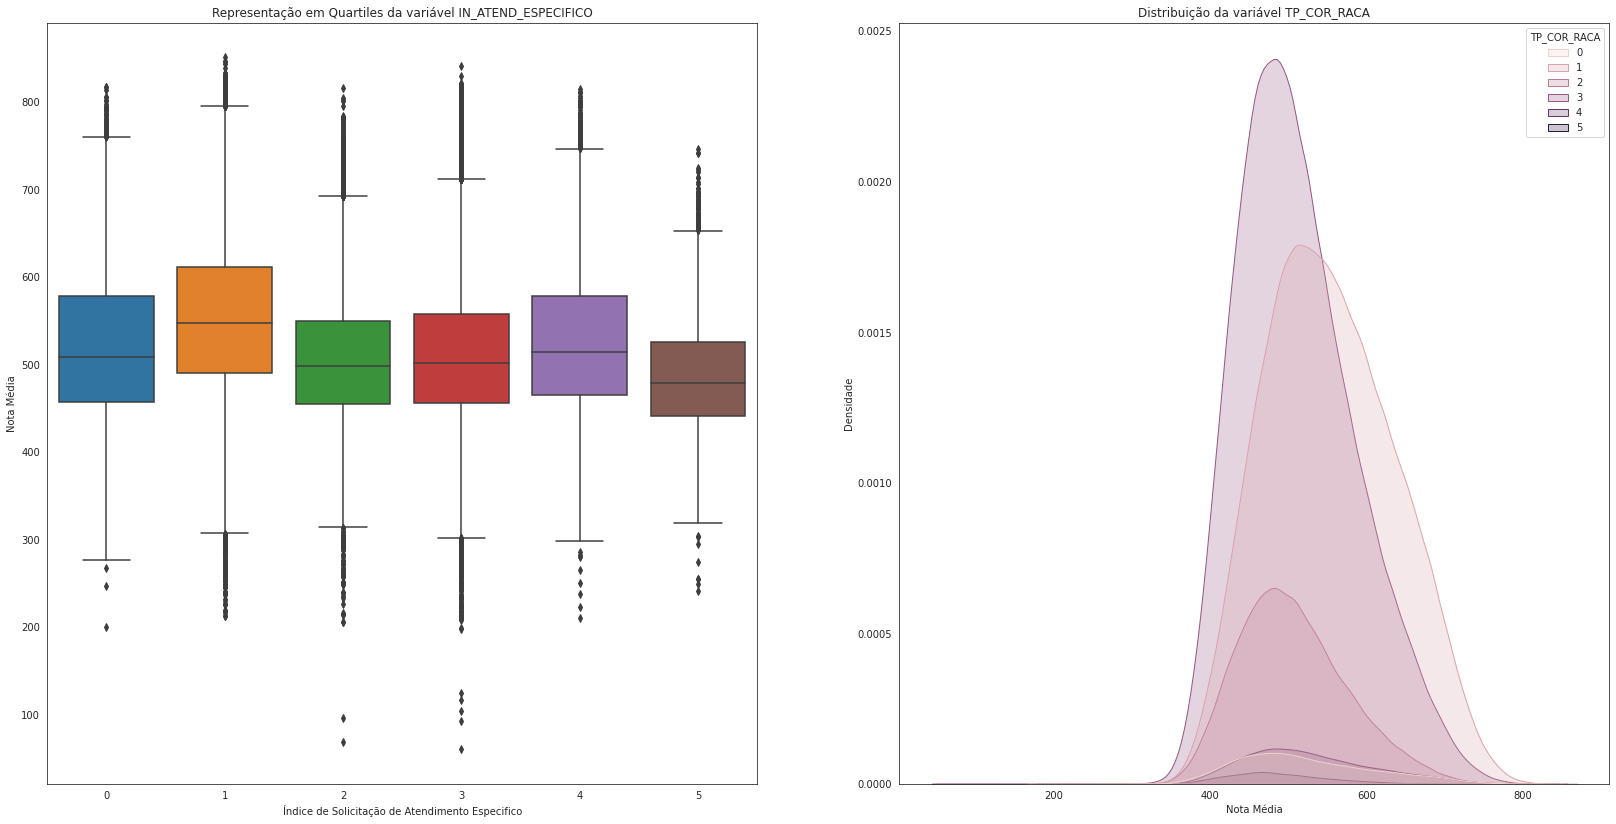

In [31]:
sns.set_style('white')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(28, 14))

# IN_ATEND_ESPECIFICO - BOXPLOT
g3 = sns.boxplot(data=df_enem2019,
                 x='TP_COR_RACA',
                 y='NU_MEDIA_NOTAS',
                 ax=ax[0])
g3.set_title('Representação em Quartiles da variável IN_ATEND_ESPECIFICO')
#g3.set_xticklabels(['Sem Atendimento', 'Com Atendimento'])     # Sendo 0 - Masc e 1 - Fem
g3.set_xlabel('Índice de Solicitação de Atendimento Especifico')
g3.set_ylabel('Nota Média')

# TP_SEXO - KDE
g6 = sns.kdeplot(data=df_enem2019,
                 x='NU_MEDIA_NOTAS',
                 hue='TP_COR_RACA',
                 fill=True,
                 ax=ax[1])
g6.set_title('Distribuição da variável TP_COR_RACA')
#g2.legend(['Feminino', 'Masculino']).set_title('Sexo')
g6.set_xlabel('Nota Média')
g6.set_ylabel('Densidade')

